In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [105]:
all_court_data = pd.read_csv('/content/gdrive/My Drive/Data/data_full.csv')

all_court_data.dropna(subset=['claimant', 'defendant'], inplace=True)

In [106]:
# how often FOP are winning

mask_claimant  = all_court_data.claimant.str.contains(r'ФОП|[Фф]ізичної особи-підприємця|[Фф]ізична особа-підприємець|ОСОБА_\d$')

mask_defendant = all_court_data.defendant.str.contains(r'ФОП|[Фф]ізичної особи-підприємця|[Фф]ізична особа-підприємець|ОСОБА_\d$')

# didn't differentiate the cases when both FOP
fop_mean = (all_court_data[mask_claimant].outcome.mean() + (1 - all_court_data[mask_defendant].outcome.mean())) / 2

print(f'FOP mean rate: {fop_mean}')

FOP mean rate: 0.4482062809720688


In [107]:
# same for companies

companies_mean = (all_court_data[~mask_claimant].outcome.mean() + (1 - all_court_data[~mask_defendant].outcome.mean())) / 2

print(f'Companies mean rate: {companies_mean}')

Companies mean rate: 0.5029558658638957


In [108]:
# now let's be more specific
# fop vs companies

samples_support_fop = all_court_data[(mask_claimant) & (~mask_defendant)].outcome.count()
mean_fop = all_court_data[(mask_claimant) & (~mask_defendant)].outcome.mean()

print(f'Samples support: {samples_support_fop}')

print(f'outcome mean: {mean_fop}')

Samples support: 3060
outcome mean: 0.4954248366013072


In [109]:
# companies vs fop

samples_support_companies = all_court_data[(~mask_claimant) & (mask_defendant)].outcome.count()
mean_companies = all_court_data[(~mask_claimant) & (mask_defendant)].outcome.mean()

print(f'Samples support: {samples_support_companies}')

print(f'outcome mean: {mean_companies}')

Samples support: 3292
outcome mean: 0.6175577156743621


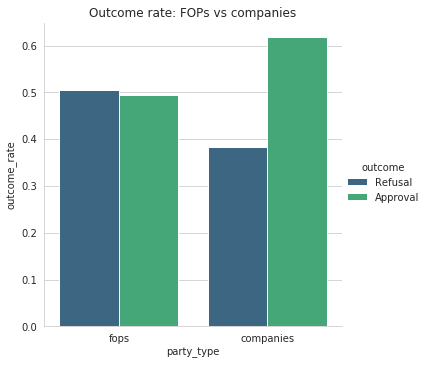

In [110]:
# let's visualize those proportions

fops_counts = all_court_data[(mask_claimant) & (~mask_defendant)].outcome.value_counts(normalize=True).to_frame('fops')
companies_counts = all_court_data[(~mask_claimant) & (mask_defendant)].outcome.value_counts(normalize=True).to_frame('companies')

joined = fops_counts.join(companies_counts).reset_index().rename({'index':'outcome'}, axis=1)
melted = pd.melt(joined, 'outcome', var_name='party_type', value_name='count')

melted['outcome'] = melted.outcome.map({0: 'Refusal', 1:'Approval'}) 

with sns.color_palette('viridis', n_colors=2):
    sns.catplot(x='party_type', y='count', hue='outcome', data=melted, kind='bar');
    plt.title('Outcome rate: FOPs vs companies')
    plt.ylabel('outcome_rate')

In [16]:
# mean durations

samples_support_fop = all_court_data[(mask_claimant)].outcome.count()
mean_fop = all_court_data[(mask_claimant)].duration_days.mean()

print(f'Samples support FOP: {samples_support_fop}')

print(f'mean duration: {mean_fop}')
print()

samples_support_companies = all_court_data[(~mask_claimant)].outcome.count()
mean_companies = all_court_data[(~mask_claimant)].duration_days.mean()

print(f'Samples support companies: {samples_support_companies}')

print(f'mean duration: {mean_companies}')

Samples support FOP: 3679
mean duration: 200.34139711878228

Samples support companies: 65632
mean duration: 164.55267247684057


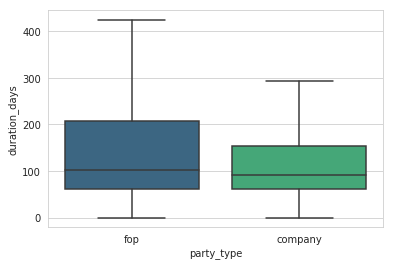

In [100]:
# however for duration with boxplot we see that median values are near the same
# on the plot we've turned off option that shows outliers
# on the original boxplot it turns out that companies have more outliers which may be the reason why mean value differs

fops_days = all_court_data[(mask_claimant) & (~mask_defendant)].duration_days
companies_days = all_court_data[(~mask_claimant) & (mask_defendant)].duration_days

fops_df = pd.DataFrame({'party_type': ['fop'] * len(fops_days), 'duration_days': fops_days})
companies_df = pd.DataFrame({'party_type': ['company'] * len(companies_days), 'duration_days': companies_days})

combined = pd.concat([fops_df, companies_df], ignore_index=True)

with sns.color_palette('viridis', n_colors=2):
    sns.boxplot(x='party_type', y='duration_days', data=combined, showfliers=False);

In [ ]:

with sns.color_palette('viridis', n_colors=2):
    sns.catplot(x='party_type', y='count', hue='outcome', data=combined, kind='bar');

In [0]:
fops = all_court_data[(mask_claimant) & (~mask_defendant)].outcome

companies = all_court_data[(~mask_claimant) & (mask_defendant)].outcome

## Trying frequenist apporach to compare difference in means

In [0]:
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

d1 = DescrStatsW(fops)
d2 = DescrStatsW(companies)

z_statistics, p_value = CompareMeans(d1, d2).ztest_ind(usevar='unequal')

print(f'z-statistics: {z_statistics}')
print(f'p_value: {p_value}')

z-statistics: -9.858255438302761
p_value: 6.313681531027556e-23


In [0]:
# let's verify our results with the formula we know is used for paired t-test

t = (fops.mean() - companies.mean()) / np.sqrt(fops.var()/len(fops) + companies.var()/len(fops))

print(t) # and it's very close

-9.688030256548734

In [0]:
# computing confidence intervals for both mean values

from statsmodels.stats.proportion import proportion_confint

fops_ci = proportion_confint(fops.sum(), len(fops))
companies_ci = proportion_confint(companies.sum(), len(companies))

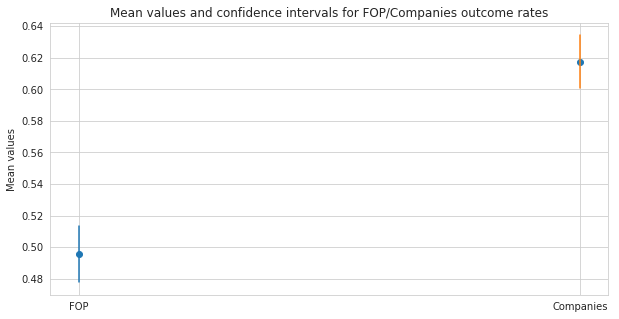

In [0]:
# let's build some visual intuition
# comparing both mean values confidence intervals we see that they're not overlapping and have a huge distance

plt.figure(figsize=(10, 5))
plt.plot([1, 1], [fops_ci[0], fops_ci[1]])
plt.plot([2, 2], [companies_ci[0], companies_ci[1]])
plt.scatter([1, 2], [fops.mean(), companies.mean()])
plt.xticks(ticks=[1, 2], labels=['FOP', 'Companies']);

plt.title('Mean values and confidence intervals for FOP/Companies outcome rates')
plt.ylabel('Mean values');

## Using hackers statistics and simulations

In [0]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # combine both data arrays
    data = np.concatenate((data1, data2))

    # permute
    permuted_data = np.random.permutation(data)

    # split permuted array into both datasets initial sizes
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [0]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # init array to store replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [0]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [0]:
# compute difference of mean in our dataset
empirical_diff_means = (diff_of_means(companies, fops))

# applying the function and drawing 10 000 permutation replicates
perm_replicates = draw_perm_reps(companies, fops,
                                 diff_of_means, size=10000)

# compute p-value
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# after computing our p-value we see that it is exactly zero
# this means that from 10 000 trials we've reached NO larger or equal difference at all
print('p-value =', p)

p-value = 0.0


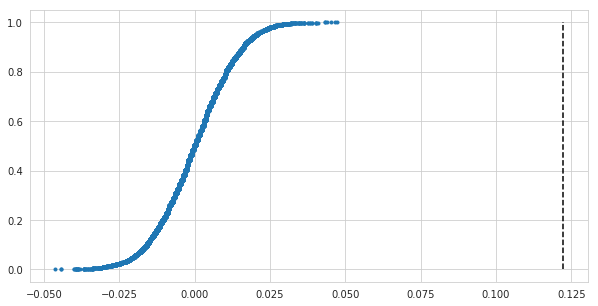

In [0]:
# some visual explanation why this happens

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    n = len(data)

    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y


x, y = ecdf(perm_replicates)

# our difference in means not even close to values with lowest probability from our permutation_replicates
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='.', linestyle='none')
plt.vlines(empirical_diff_means, linestyle='--', ymin=0, ymax=1);

In [0]:
# using bootstraping with two datasets instead of permutation that we used before for difference in means

empirical_diff_means = diff_of_means(companies, fops)

comapnies_and_fops = np.concatenate((companies, fops))

# initialize empty array for bootstrap replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # generate bootstrap sample
    bs_sample = np.random.choice(comapnies_and_fops, size=len(comapnies_and_fops))
    
    # compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(companies)],
                                     bs_sample[len(fops):])

# computing p-value and again we have zero
p = np.sum(bs_replicates > empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


## Bayesian approach and Monte Carlo simulations

In [18]:
# we'll be using pystan to run our Monte Carlo simulations

import pystan

# The Stan model as a string.
model_string = """
# Here we define the data we are going to pass into the model
data {
  int n1; # Number of trials
  int n2; # Number of trials
  int s1;  # Number of successes
  int s2;  # Number of successes
}

# Here we define what 'unknowns' aka parameters we have.
parameters {
  real<lower=0, upper=1> rate_1;
  real<lower=0, upper=1> rate_2;
}

# The generative model
# actually need to switch some order here - look to the solution for correct use, anyway Stan handled the issue
model {
  rate_1 ~ uniform(0, 1);
  s1 ~ binomial(n1, rate_1);

  rate_2 ~ uniform(0, 1);
  s2 ~ binomial(n2, rate_2);
}

# In the generated quantiles block you can calculate 'derivatives' of
# the parameters. Here is a silly example calculating the square of the 
# rate. Variables have to be defined before they are assigned to.
generated quantities {
  real diff_rate;
  diff_rate <- rate_1 - rate_2;
}
"""

# number of trials
n_companies = len(companies)
n_fops = len(fops)

# number of successes in n trials
companies_successes = int(companies.sum())
fops_successes = int(fops.sum())

data_list = dict(n1=n_companies, n2=n_fops,  s1=companies_successes, s2=fops_successes)

# Compiling and producing posterior samples from the model.
stan_samples = pystan.stan(model_code=model_string, data=data_list)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cebd754f94b17301a427ca1b00978dc0 NOW.


In [19]:
# summary table

print(stan_samples)

Inference for Stan model: anon_model_cebd754f94b17301a427ca1b00978dc0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate_1      0.62  1.5e-4 8.6e-3    0.6   0.61   0.62   0.62   0.63   3207    1.0
rate_2       0.5  1.6e-4 9.0e-3   0.48   0.49    0.5    0.5   0.51   3289    1.0
diff_rate   0.12  2.2e-4   0.01    0.1   0.11   0.12   0.13   0.15   3266    1.0
lp__       -4314    0.02    1.0  -4317  -4315  -4314  -4314  -4313   1813    1.0

Samples were drawn using NUTS at Wed May 22 14:12:12 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
# extracting our posterior distribution to dataframe

posterior = pd.DataFrame(stan_samples.extract())

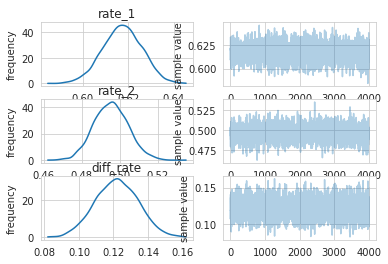

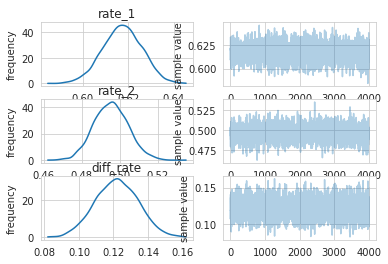

In [21]:
# plotting simulated distributions for fops, companies and posterior distributions for difference in means

stan_samples.plot()

In [24]:
# all of the samples have difference in means above zero, which means that we have statistically significant result

print(f'Percent where simulated data has difference in means above zero: {sum(posterior.diff_rate > 0) / len(posterior.diff_rate) * 100}%')

Percent where simulated data has difference in means above zero: 100.0%


In [25]:
# example of generated data

posterior.head()

,rate_1,rate_2,diff_rate,lp__
0,0.626296,0.467099,0.159197,-4319.195950
1,0.615073,0.516065,0.099007,-4316.375152
2,0.616994,0.509681,0.107313,-4314.971241
3,0.613667,0.477572,0.136095,-4315.781319
4,0.623093,0.499783,0.123311,-4314.061399


In [26]:
# posterior distribution difference in means - almost the same difference as in our dataset

posterior.diff_rate.mean()

0.12194277669833574

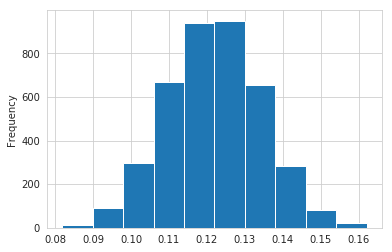

In [38]:
# histogram of our posterior distribution for difference in means, as we see, there is no way to get less than 0.08 difference in means

posterior.diff_rate.plot.hist();

In [46]:
# summary: number of draws, median and 95% interval
# so we can say that we're 95% confident that our difference in means is between 0.098 and 0.146

print('Number of draws: %d, Posterior median: %.3f, Posterior 95 percent quantile interval: %.3f-%.3f' % 
      (len(posterior), posterior.diff_rate.median(), posterior.diff_rate.quantile(.025), posterior.diff_rate.quantile(.975)))

Number of draws: 4000, Posterior median: 0.122, Posterior 95 percent quantile interval: 0.098-0.146


## Trying out different approaches we end up with same results that clearly state that we have statistically significant difference in mean values. Thus, we might suggest that companies indeed have higher chance to win in a court trial, than FOPs. 